In [198]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=5
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    #iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>1.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
        
        while sum(mask)>max_star:
            if any([binfs_new[jj]<0.5*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        #iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    #df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,vz='v_b'):
    countsNo=0
    min_star=20
    max_star=30
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>1.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
         
        
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)
    #print(v_to_age(kin_age,p_mr))
    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,sampsize=50,vz='v_b'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        print(fs[i])
        newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new')
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):
    min_star=5
    max_star=30
    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df,df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df,df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        #print(binfs)
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])
        
            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>1.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                #print(len(vels_single),binfs_new)
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        if errVals:
            df_test=df_common.dropna(subset=['veldisp','kin_age','kin_age_err'])
        else:
            df_test=df_common.dropna(subset=['veldisp','kin_age'])
        
        if len(df_test)==0:
            continue 
        
        if count==0:
            if errVals:
                sigma=np.power(df_test[df_match_name_err],2.)+np.power(df_test['kin_age']*df_test['kin_age_err'],2.)
                chisq=sum(np.power(df_test[df_match_name]-df_test['kin_age'],2.)/sigma/len(df_test))
            else:
                chisq=sum(np.power(df_test[df_match_name]-df_test['kin_age'],2.)/np.power(df_test[df_match_name_err],2.))/len(df_test)
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=np.power(df_test[df_match_name_err],2.)+np.power(df_test['kin_age']*df_test['kin_age_err'],2.)
                chisq_new=sum(np.power(df_test[df_match_name]-df_test['kin_age'],2.)/sigma/len(df_test))
            else:        
                chisq_new=sum(np.power(df_test[df_match_name]-df_test['kin_age'],2.)/np.power(df_test[df_match_name_err],2.))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
            count=count+1
        #print(chisq)
        
    print(opt_binsize)
    # calculate with optimized bin
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])
        
        mask=np.ones(len(df), dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)
            vels_single=vels[mask]
            binfs_new=binfs
            
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>1.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                #print(len(vels_single),binfs_new)
            
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]
    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']*df_common['kin_age']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq



def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        

# For stars with Prot

In [3]:
#df_ruth=pd.read_table('all_rvs.csv',delimiter=',')
df_ruth=pd.read_pickle('df_ruth.pkl')

In [29]:
df_ruth['all_vz_err']=df_ruth.vz_inferred_err

In [30]:
vzerr=df_ruth['all_vz_err'].values
vberr=df_ruth['v_b_err'].values
for i in range(len(vzerr)):
    if np.isnan(vzerr[i]):
        vzerr[i]=vberr[i]

In [32]:
df_ruth['all_vz_err']=vzerr

In [8]:
#df_ruth.to_pickle('df_ruth.pkl')
df_ruth=pd.read_pickle('df_ruth.pkl')

In [20]:
df_ruth=df_ruth.loc[df_ruth['Prot_err']<10]
df_ruth=df_ruth.loc[df_ruth['teff_err1']<500]
df_ruth=df_ruth.loc[df_ruth['Ro_err']<1]
df_ruth=df_ruth.reset_index(drop=True)

31025


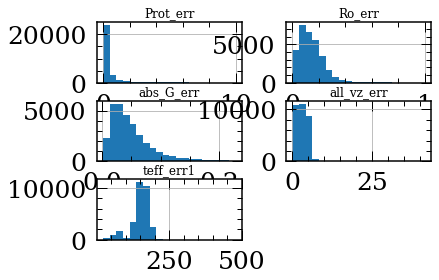

In [30]:
df_ruth[['Prot_err','teff_err1','abs_G_err','Ro_err','all_vz_err']].hist(bins=20)
print(len(df_ruth))

In [3]:
# calculate errors 
ages=getkinAges_err(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],[150.0, 0.14, 0.45, 0.14],vz='all_vz')
df_ruth['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]/df_ruth['kin_age']



color_teffs
Prot_log
abs_G
Ro


  1%|          | 260/31025 [00:00<00:11, 2596.80it/s]

0.0


100%|██████████| 31025/31025 [00:11<00:00, 2740.61it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  1%|          | 260/31025 [00:00<00:11, 2594.35it/s]

0.02


  1%|          | 255/31025 [00:00<00:12, 2542.50it/s]

0.04


  1%|          | 267/31025 [00:00<00:11, 2662.33it/s]

0.06


  1%|          | 278/31025 [00:00<00:11, 2777.74it/s]

0.08


  1%|          | 273/31025 [00:00<00:11, 2722.10it/s]

0.1


  1%|          | 271/31025 [00:00<00:11, 2705.38it/s]

0.12


  1%|          | 263/31025 [00:00<00:11, 2624.86it/s]

0.14


  1%|          | 273/31025 [00:00<00:11, 2721.57it/s]

0.16


  1%|          | 269/31025 [00:00<00:11, 2689.22it/s]

0.18


  1%|          | 278/31025 [00:00<00:11, 2771.69it/s]

0.2


  1%|          | 269/31025 [00:00<00:11, 2687.90it/s]

0.22


  1%|          | 259/31025 [00:00<00:11, 2587.10it/s]

0.24


  1%|          | 279/31025 [00:00<00:11, 2788.80it/s]

0.26


  1%|          | 250/31025 [00:00<00:12, 2493.05it/s]

0.28


  1%|          | 270/31025 [00:00<00:11, 2694.09it/s]

0.3


  1%|          | 267/31025 [00:00<00:11, 2668.01it/s]

0.32


  1%|          | 269/31025 [00:00<00:11, 2683.21it/s]

0.34


  1%|          | 267/31025 [00:00<00:11, 2661.51it/s]

0.36


  1%|          | 265/31025 [00:00<00:11, 2646.61it/s]

0.38


  1%|          | 271/31025 [00:00<00:11, 2707.94it/s]

0.4


  1%|          | 268/31025 [00:00<00:11, 2675.21it/s]

0.42


  1%|          | 276/31025 [00:00<00:11, 2755.89it/s]

0.44


  1%|          | 268/31025 [00:00<00:11, 2677.86it/s]

0.46


  1%|          | 269/31025 [00:00<00:11, 2681.31it/s]

0.48


  1%|          | 275/31025 [00:00<00:11, 2742.40it/s]

0.5


  1%|          | 264/31025 [00:00<00:11, 2635.36it/s]

0.52


  1%|          | 183/31025 [00:00<00:16, 1823.72it/s]

0.54


  1%|          | 276/31025 [00:00<00:11, 2753.94it/s]

0.56


  1%|          | 264/31025 [00:00<00:11, 2632.16it/s]

0.58


  1%|          | 268/31025 [00:00<00:11, 2679.90it/s]

0.6


  1%|          | 250/31025 [00:00<00:12, 2494.91it/s]

0.62


  1%|          | 253/31025 [00:00<00:12, 2522.18it/s]

0.64


  1%|          | 271/31025 [00:00<00:11, 2703.13it/s]

0.66


  1%|          | 274/31025 [00:00<00:11, 2737.16it/s]

0.68


  1%|          | 272/31025 [00:00<00:11, 2713.06it/s]

0.7


  1%|          | 270/31025 [00:00<00:11, 2695.45it/s]

0.72


  1%|          | 259/31025 [00:00<00:11, 2584.41it/s]

0.74


  1%|          | 264/31025 [00:00<00:11, 2633.89it/s]

0.76


  1%|          | 245/31025 [00:00<00:12, 2447.28it/s]

0.78


  1%|          | 275/31025 [00:00<00:11, 2749.98it/s]

0.8


  1%|          | 268/31025 [00:00<00:11, 2672.67it/s]

0.82


  1%|          | 217/31025 [00:00<00:14, 2165.66it/s]

0.84


  1%|          | 236/31025 [00:00<00:13, 2353.67it/s]

0.86


  1%|          | 259/31025 [00:00<00:11, 2583.41it/s]

0.88


  1%|          | 279/31025 [00:00<00:11, 2786.93it/s]

0.9


  1%|          | 270/31025 [00:00<00:11, 2695.01it/s]

0.92


  1%|          | 202/31025 [00:00<00:15, 2009.87it/s]

0.94


  1%|          | 243/31025 [00:00<00:12, 2424.91it/s]

0.96


  1%|          | 166/31025 [00:00<00:18, 1655.01it/s]

0.98


100%|██████████| 31025/31025 [00:12<00:00, 2429.26it/s]


In [7]:
df_ruth['kin_age_err']

0         6.979806
1         0.832421
2         1.679198
3         0.398198
4         0.808009
           ...    
31020     0.449142
31021     1.864018
31022     0.206054
31023     0.501083
31024    36.595635
Name: kin_age_err, Length: 31025, dtype: float64

In [50]:

#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17])
#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[200.0, 0.4, 0.5])
df_ruth['Prot_log']=np.log10(df_ruth['Prot'])
df_ruth['vel_dis'],df_ruth['kin_age']=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],vz='all_vz')




"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

100%|██████████| 31025/31025 [00:17<00:00, 1799.81it/s]


4847


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

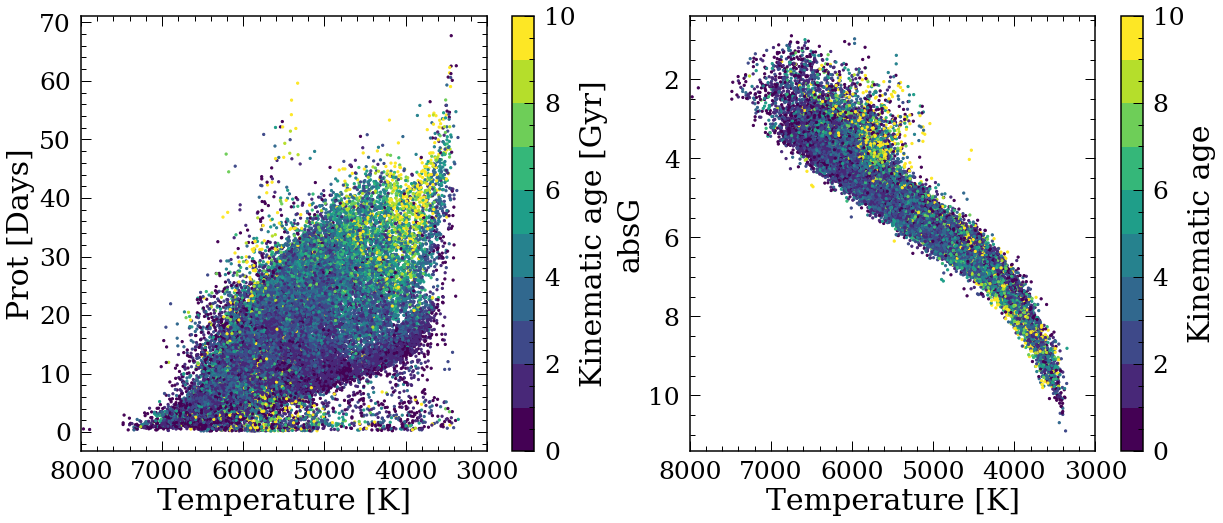

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',10)

plt.scatter(df_ruth['color_teffs'],df_ruth['Prot'],c=df_ruth['kin_age'],s=5,vmin=0,vmax=10,cmap=cm,edgecolors=None)
plt.xlim([3000,8000])
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Kinematic age [Gyr]')

plt.subplot(1,2,2)
cm = plt.cm.get_cmap('viridis',10)
plt.xlim([3000,8000])
plt.scatter(df_ruth['color_teffs'],df_ruth['abs_G'],c=df_ruth['kin_age'],s=5,vmin=0,vmax=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('absG')

cb=plt.colorbar()

cb.set_label('Kinematic age')



In [51]:
# read in AS stars

ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])

seismicKID=[12069424,12069449,3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755]

seismicAge=[7.07,6.82,2.23,8.13,4.17,6.23,5.51,6.24,7.19,9.15,5.04,7.93,7.28,1.71,6.43,2.03,6.35,
            1.07,4.36,6.43,5.85]
seismicAge_err=[0.46,0.28,0.17,0.59,0.40,0.37,0.71,0.37,0.70,0.47,0.17,0.94,0.51,0.19,0.47,0.29,
                1.37,0.25,0.46,0.58,0.93]


for i in ASstars['KIC'].unique():
    AS_single=ASstars.loc[ASstars['KIC']==i]
    seismicKID.append(int(i))
    seismicAge.append(np.mean(AS_single['Age']))
    seismicAge_err.append((max(AS_single['Age'])-min(AS_single['Age']))/2.)

ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')

seismicKID=np.append(seismicKID,ASstars_van['KIC'].values)    
seismicAge=np.append(seismicAge,ASstars_van['AMP_age'].values)    
seismicAge_err=np.append(seismicAge_err,ASstars_van['AMP_age_err'].values)    
    
All_ASstars=pd.DataFrame(np.array((seismicKID,seismicAge,seismicAge_err)).T,
                        columns=['KID','ASAge','ASAge_err'])


All_ASstars=pd.merge(All_ASstars,gaia,left_on='KID',right_on='kepid',how='inner')
All_ASstars=All_ASstars.drop_duplicates(keep='first')
print(np.shape(All_ASstars))

pred_period = 10**gk_rotation_model(np.log10(All_ASstars.ASAge.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
"""
# only use vansandar stars
ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')
All_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')
All_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])

All_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])
pred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
m=abs(All_ASstars['predict_period']-All_ASstars['period'])<5
All_ASstars=All_ASstars[m]
print(np.shape(All_ASstars))
"""


(86, 137)


"\n# only use vansandar stars\nASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')\nAll_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')\nAll_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])\n\nAll_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])\npred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)\nAll_ASstars['predict_period']=pred_period\nm=abs(All_ASstars['predict_period']-All_ASstars['period'])<5\nAll_ASstars=All_ASstars[m]\nprint(np.shape(All_ASstars))\n"

In [43]:
All_ASstars

,KID,ASAge,ASAge_err,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,...,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist,predict_period
0,12069424.0,7.070000,0.46000,1.635721e+18,Gaia DR2 2135550755683405952,2.135551e+18,4.015756e+08,2015.5,295.452970,0.030352,...,DSEP,0.0,0.0,0.0,5.091,4.724,4.426,none,0.022439,34.518144
1,12069424.0,6.973883,0.42960,1.635721e+18,Gaia DR2 2135550755683405952,2.135551e+18,4.015756e+08,2015.5,295.452970,0.030352,...,DSEP,0.0,0.0,0.0,5.091,4.724,4.426,none,0.022439,34.213746
3,12069449.0,6.820000,0.28000,1.635721e+18,Gaia DR2 2135550755683407232,2.135551e+18,1.660575e+08,2015.5,295.465642,0.022583,...,DSEP,1.0,0.0,0.0,4.993,4.695,4.651,conf,0.057565,34.803445
4,12069449.0,7.088967,0.23710,1.635721e+18,Gaia DR2 2135550755683407232,2.135551e+18,1.660575e+08,2015.5,295.465642,0.022583,...,DSEP,1.0,0.0,0.0,4.993,4.695,4.651,conf,0.057565,35.685559
6,3427720.0,2.230000,0.17000,1.635721e+18,Gaia DR2 2099985402815368704,2.099985e+18,1.356349e+09,2015.5,286.438256,0.021006,...,DSEP,0.0,0.0,0.0,8.094,7.843,7.826,none,0.029800,12.137496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,11772920.0,10.203517,0.66100,1.635721e+18,Gaia DR2 2135275740337869056,2.135276e+18,1.500761e+09,2015.5,296.441846,0.025694,...,DSEP,0.0,0.0,0.0,8.435,8.031,7.981,none,0.053119,56.567089
103,12009504.0,3.743300,0.51110,1.635721e+18,Gaia DR2 2133099635026671488,2.133100e+18,2.906804e+08,2015.5,289.440885,0.021180,...,DSEP,0.0,0.0,0.0,8.373,8.149,8.069,none,0.067441,12.522157
104,12069127.0,1.848333,0.12575,1.635721e+18,Gaia DR2 2135179700570225024,2.135180e+18,6.806487e+08,2015.5,295.303272,0.020980,...,DSEP,0.0,0.0,0.0,9.733,9.524,9.494,none,0.063575,7.068682
105,12258514.0,4.514033,0.86915,1.635721e+18,Gaia DR2 2136139475439597184,2.136139e+18,1.138587e+09,2015.5,291.592239,0.026103,...,DSEP,0.0,0.0,0.0,7.035,6.797,6.758,none,0.307228,19.360004


In [264]:

    
def compstars(df,err=True,ave=False,IOfile=False):
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]

    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)

    
    # Isochrone stars
    df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
    IAcomp=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')

    if ave:
        IAcomp['vel_dis'],IAcomp['iso_age_ave']=getAveAges(IAcomp,['color_teffs','Prot_log','abs_G','Ro'],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],vz='all_vz')
    
    if IOfile:
        IAcomp=np.load('XD.npy')
    else:
        IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
        IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]
        IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]
        
    if ave:
        IAcomp.to_pickle('IsoStars.pkl')
        
        
    # WD ages
    WDKID=[12456401,11075611]
    WDage=[3.59,3.64]
    WDage_err=[4.92,3.05]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    
    
    plt.figure(figsize=(10,8))
    if err:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages')
    else:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],fmt='go',label='AS ages')
    if IOfile:
        plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    elif ave:
        plt.plot(IAcomp['iso_age_ave'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    else:
        plt.plot(IAcomp['iso_age'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
        
    plt.errorbar(ages_cluster,ages,yerr=ages_err,fmt='ro',label='Clusters')
    plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    plt.plot([0,10],[0,10])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Gyro-Kinematic Age [Gyr]')
    plt.xlabel('Measured Age [Gyr]')
    

## optimize bin size

In [24]:
ASstars=pd.merge(df_ruth,All_ASstars,left_on='KID',right_on='KID',how='inner')
#ASstars=ASstars.loc[abs(ASstars['Prot']-ASstars['predict_period'])<5]
    
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['color_teffs','Prot_log','abs_G','Ro'],
                             [50,0.1,0.1,0.1],[500,0.3,0.5,0.5],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='all_vz',bintestNo=10,errVals=True)
""" 

optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['color_teffs','Prot_log','abs_G','Ro'],
                             [150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],[151.0, 0.15, 0.46, 0.15],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='all_vz',bintestNo=1,errVals=True)


100%|██████████| 7/7 [00:00<00:00, 497.01it/s]

[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]


optimized bin size: [150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446] . with chisq: 0.010811950277396147


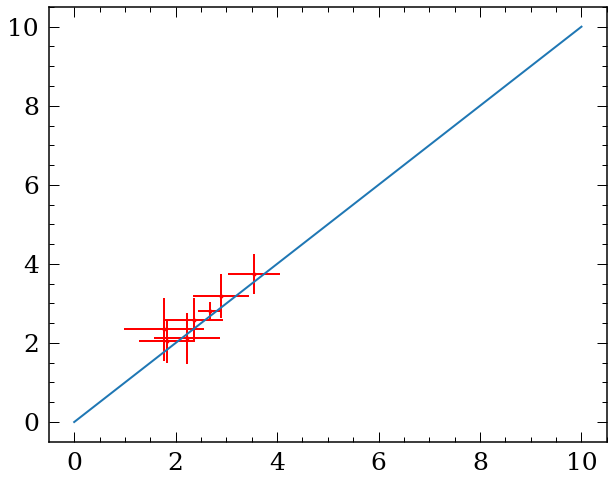

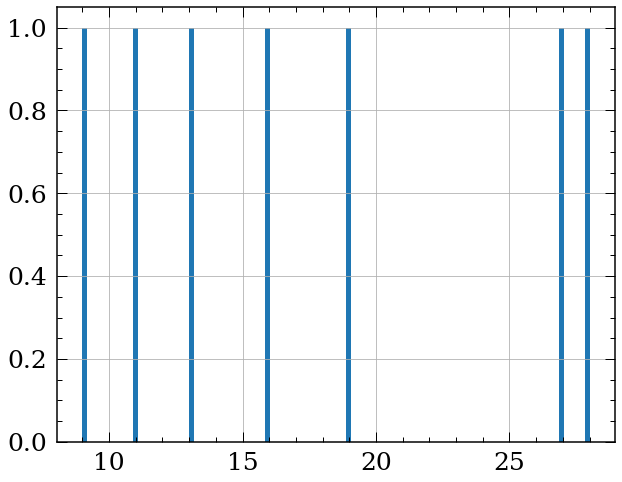

In [25]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],xerr=out_comp['measure_age_err'],
             yerr=out_comp['measure_age_err'],fmt='r.')
plt.plot([0,10],[0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [19]:
#df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])

df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df_ruth,left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [20]:
np.shape(IAcomp)

(8669, 252)

In [21]:

optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=1,errVals=True)
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)
"""
#[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]
#[500.0, 0.5, 0.46, 0.5]

  0%|          | 0/1 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▏         | 122/8669 [00:00<00:07, 1218.10it/s]

[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]


100%|██████████| 8669/8669 [00:07<00:00, 1217.34it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


"\noptbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],\n                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',\n                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)\n"

In [23]:
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

optimized bin size: [150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446] . with chisq: 0.9686452300654186
0.19228620689610887


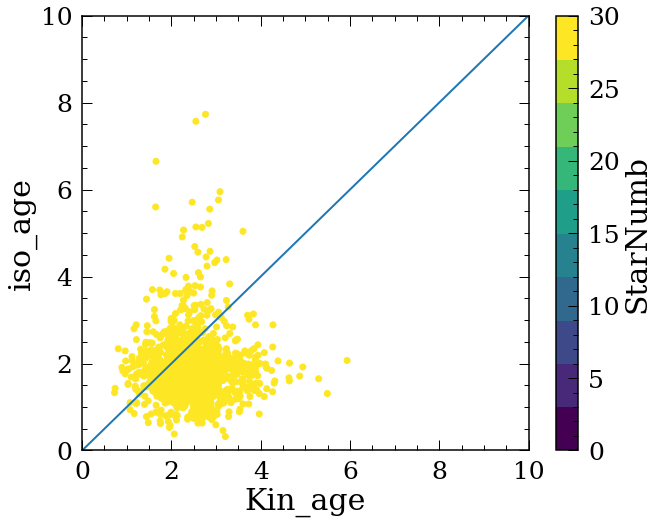

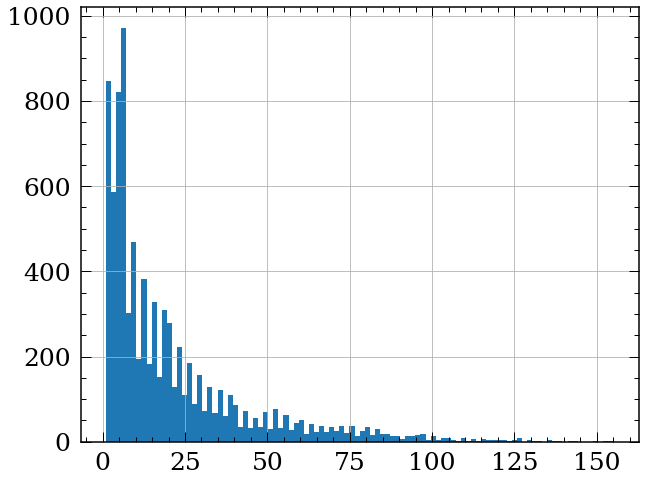

In [118]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
out_comp_plot=out_comp.loc[out_comp['NumbStars']>40].dropna()
out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<100].dropna()
print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],out_comp_plot['kin_age_err'],out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=0,vmax=30)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

# Final compare

(13, 358)
(7, 358)
Pleiades
Praesepe
Hyades
NGC_752
Ruprecht_147
NGC_6819
NGC_6811


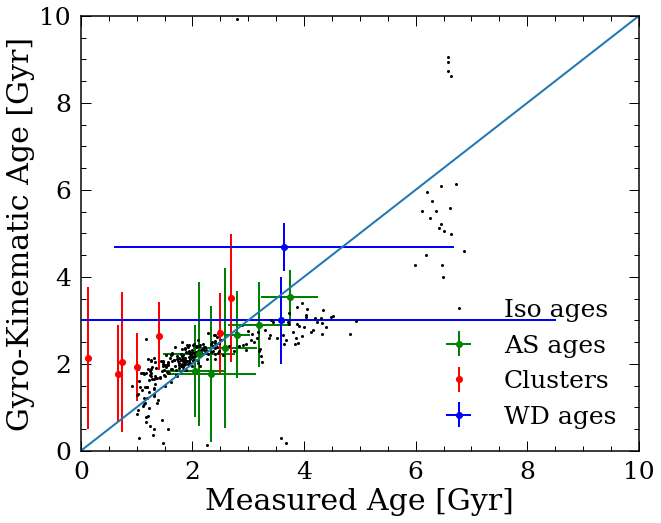

In [266]:
#df_ruth['kin_age']=df_ruth['age']
compstars(df_ruth,err=True,IOfile=True)
plt.savefig('Figures/FinalComp.png')

# Compare star numbers in each bin

In [105]:
df_ruth['nostars']=countstars(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446])



100%|██████████| 31025/31025 [45:20<00:00, 11.40it/s]  


In [271]:
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
df_ruth=pd.merge(df_isoages,df_ruth,left_on='KIC',right_on='KID',how='inner')

In [272]:
df_ruth.to_pickle('df_ruth.pkl')

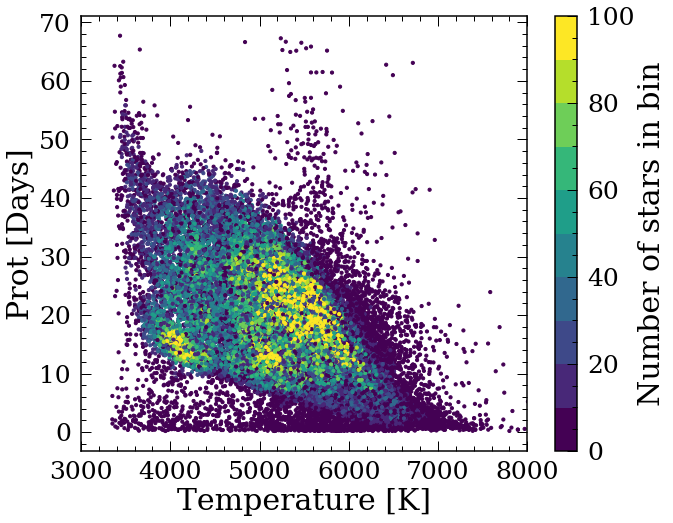

In [112]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_ruth['color_teffs'],df_ruth['Prot'],c=df_ruth['nostars'],s=10,vmin=0,vmax=100,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Prot [Days]')
plt.xlim([3000,8000])
cb=plt.colorbar()

cb.set_label('Number of stars in bin')



# For stars without Prot

In [234]:
df=pd.read_pickle('KinageAllKepler_cut.pkl')

print(np.shape(df))
# drop duplicates
df=df.drop_duplicates(subset ="KID", keep = 'first') 
df=df.reset_index(drop=True)
print(np.shape(df))
df


(165753, 150)
(165739, 150)


,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,Av_errp,Av_errm,Av_std,bp_dered,rp_dered,bprp_dered,G_dered,teff_calc,abs_G,Prot_predict
0,1.635721e+18,Gaia DR2 2050233807328471424,2.050234e+18,6.894055e+08,2015.5,291.038681,0.035878,36.598031,0.047832,1.493916,...,0.009323,0.009323,0.009323,11.777006,10.774865,1.002141,11.345285,5258.348073,2.216916,20.483619
1,1.635721e+18,Gaia DR2 2050233601176543104,2.050234e+18,4.473825e+08,2015.5,291.043057,0.019919,36.593767,0.027553,2.678194,...,0.022417,0.022417,0.022417,13.361525,12.369631,0.991894,12.947337,5285.025302,5.086547,4.249750
2,1.635721e+18,Gaia DR2 2050230611879323904,2.050231e+18,1.253667e+09,2015.5,291.095373,0.016886,36.564903,0.022993,1.183652,...,0.000000,0.000000,0.000000,11.553965,11.067600,0.486364,11.367806,6917.117893,1.733926,2.866350
3,1.635721e+18,Gaia DR2 2050231848829944320,2.050232e+18,2.980325e+08,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,0.018646,0.018646,0.018646,15.240799,14.264825,0.975974,14.829724,5327.028622,5.168635,15.227621
4,1.635721e+18,Gaia DR2 2050246795316077952,2.050247e+18,1.487775e+09,2015.5,290.955123,0.089275,36.689196,0.104870,0.827378,...,0.007809,0.007809,0.007809,13.201027,12.588211,0.612816,12.975954,6456.866533,2.564473,7.617800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165734,1.635721e+18,Gaia DR2 2139341768695774336,2.139342e+18,1.626857e+09,2015.5,290.033980,0.031699,52.439817,0.030193,1.052836,...,0.018646,0.018646,0.018646,16.027684,14.949110,1.078574,15.558916,5068.266081,5.670720,17.349715
165735,1.635721e+18,Gaia DR2 2139341906134738432,2.139342e+18,2.558871e+08,2015.5,290.058448,0.026208,52.453856,0.026837,0.807338,...,0.000000,0.000000,0.000000,15.708975,14.730165,0.978811,15.316444,5319.495846,4.851720,23.743965
165736,1.635721e+18,Gaia DR2 2139330017665253888,2.139330e+18,1.019010e+09,2015.5,290.067749,0.019151,52.415316,0.018894,0.577283,...,0.002875,0.002875,0.002875,14.668786,13.885172,0.783615,14.352905,5886.480850,3.159849,17.732202
165737,1.635721e+18,Gaia DR2 2139330636140575616,2.139331e+18,1.154749e+09,2015.5,290.123457,0.021062,52.474732,0.021276,1.754986,...,0.027968,0.027968,0.027968,12.724442,11.929860,0.794582,12.397971,5852.103506,3.619340,41.485400


In [235]:
# get velocity, teff, abs G
df['v_t'],df['v_b']=Astraea.getVs(df)



In [238]:
print(np.shape(df))
df=df.loc[df['teff_calc']>3000]
df=df.loc[df['teff_calc']<8000]
print(np.shape(df))

df['Prot_log']=np.log10(df['Prot_predict'])
df['Ro']=df['Prot_predict']/stardate.convective_overturn_time(df['mass'])


(165252, 151)
(165252, 151)


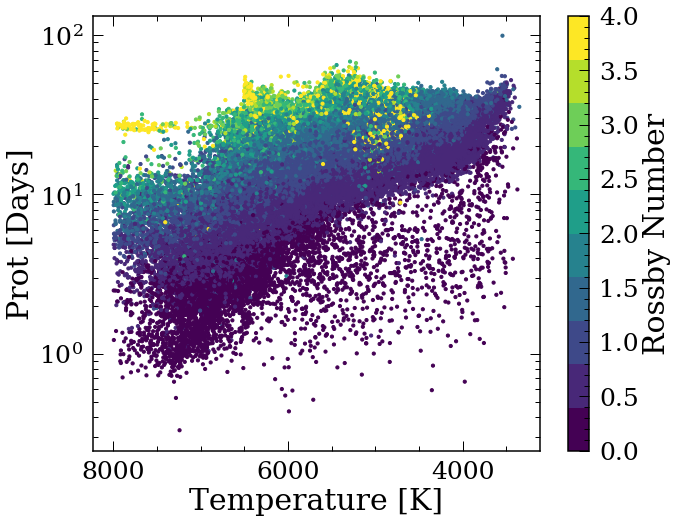

In [239]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['Prot_predict'],c=df['Ro'],s=10,vmin=0,vmax=4,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Rossby Number')


In [151]:
# Cut binaries
z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
   -3.54673368e-01,3.51882114e+02]
p = np.poly1d(z)

print(np.shape(df))
m1=df['abs_G']<p(df['teff_calc'])-0.3
m2=df['teff_calc']<8000
m=m1&m2
#df=df[~m]
#df=df.loc[df['abs_G']>4]
print(np.shape(df))

(33470, 151)
(33470, 151)


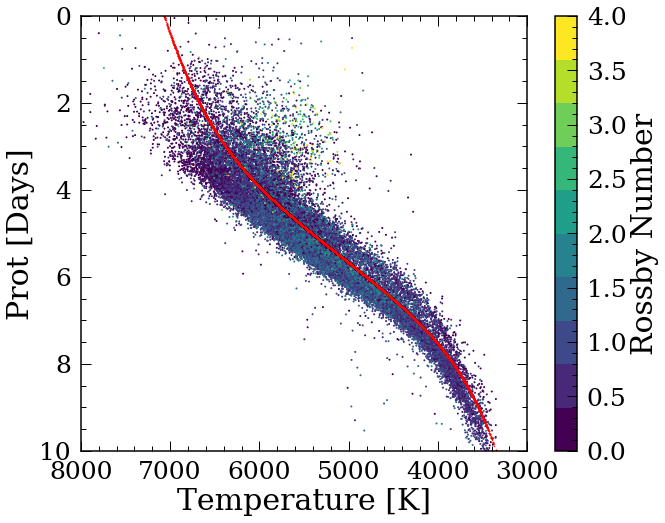

In [244]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_ruth['color_teffs'],df_ruth['abs_G'],c=df_ruth['Ro'],s=1,vmin=0,vmax=4,cmap=cm,edgecolors=None)
plt.plot(df_ruth['color_teffs'],p(df_ruth['color_teffs'])-0.1,'r.',markersize=1)
plt.ylim([0,10])
plt.xlabel('Temperature [K]')
plt.xlim([3000,8000])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Rossby Number')




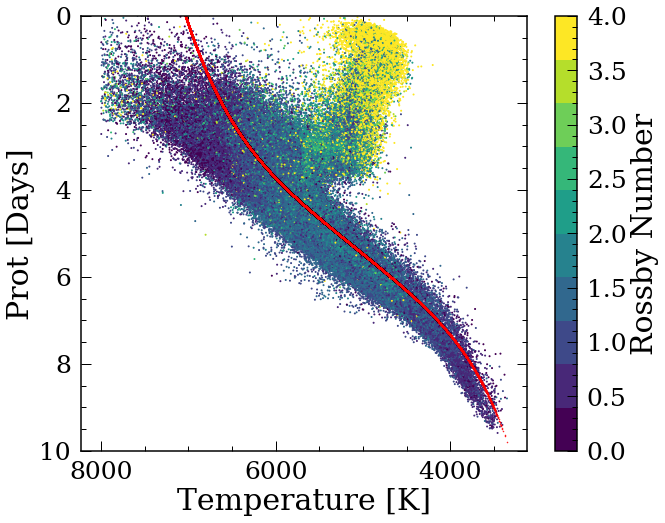

In [245]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['abs_G'],c=df['Ro'],s=1,vmin=0,vmax=4,cmap=cm,edgecolors=None)
plt.plot(df['teff_calc'],p(df['teff_calc'])-0.3,'r.',markersize=1)
plt.ylim([0,10])
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Rossby Number')


In [246]:
ASstars=pd.merge(df,All_ASstars,left_on='KID',right_on='KID',how='inner')
print(len(ASstars))
#ASstars=ASstars.loc[abs(ASstars['Prot']-ASstars['predict_period'])<5]
    
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['color_teffs','Prot_log','abs_G','Ro'],
                             [50,0.1,0.1,0.1],[500,0.3,0.5,0.5],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='all_vz',bintestNo=10,errVals=True)
""" 

optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [50, 0.1, 0.1, 0.1],[500.0, 0.5, 0.5, 0.5],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='v_b',bintestNo=10,errVals=False)



86


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  5%|▍         | 4/86 [00:00<00:02, 35.90it/s]

[350.0, 0.1, 0.14444444444444446, 0.1]


100%|██████████| 86/86 [00:02<00:00, 29.74it/s]


optimized bin size: [350.0, 0.1, 0.14444444444444446, 0.1] . with chisq: 51.28850123468582


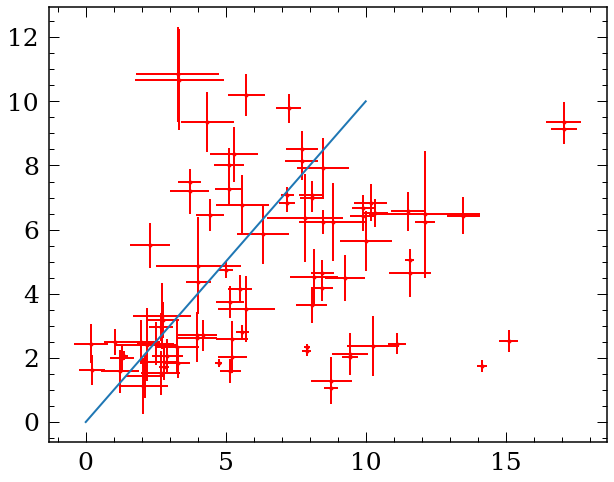

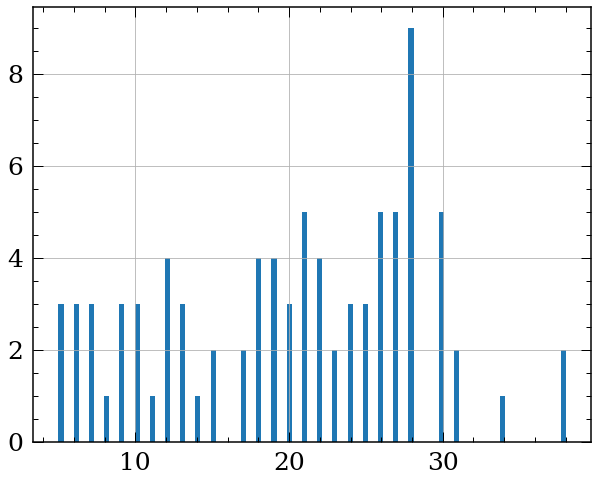

In [248]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],xerr=out_comp['measure_age_err'],
             yerr=out_comp['measure_age_err'],fmt='r.')

plt.plot([0,10],[0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [249]:
#df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])

df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [250]:

optbin,out_comp,chisq=optimizeBins(df,IAcomp,['teff_calc','Prot_log','abs_G','Ro'],
                             [350.0, 0.1, 0.14444444444444446, 0.1],[351.0, 0.11, 0.15, 0.11],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='v_b',bintestNo=1,errVals=False)
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)
"""
#[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]
#[500.0, 0.5, 0.46, 0.5]

  0%|          | 9/71839 [00:00<13:27, 88.92it/s]

[350.0, 0.1, 0.14444444444444446, 0.1]


100%|██████████| 71839/71839 [10:26<00:00, 114.60it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


"\noptbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],\n                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',\n                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)\n"

optimized bin size: [350.0, 0.1, 0.14444444444444446, 0.1] . with chisq: inf
6.728267483328311


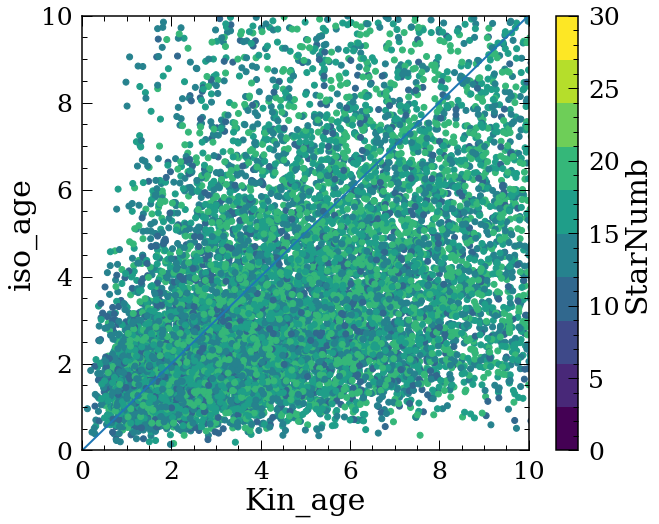

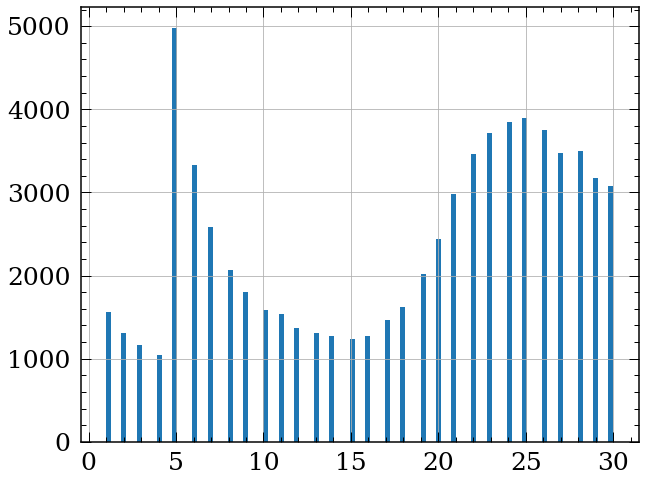

In [254]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
out_comp_plot=out_comp.loc[out_comp['NumbStars']>10].dropna()
out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<20].dropna()
print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],np.ones(len(out_comp_plot)),out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=0,vmax=30)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [252]:

#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17])
#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[200.0, 0.4, 0.5])

df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G','Ro'],[350.0, 0.1, 0.14444444444444446, 0.1],vz='v_b')

"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

  0%|          | 0/165252 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in less
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in less
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in less
  0%|          | 582/165252 [00:04<19:35, 140.05it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 165252/165252 [17:41<00:00, 155.73it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


210147


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

In [260]:
print(np.shape(df))
df=df.dropna(subset=['kin_age']).reset_index(drop=True)
print(np.shape(df))

(165252, 154)
(159289, 154)


In [259]:
# calculate errors 
ages=getkinAges_err(df,['teff_calc','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],[350.0, 0.1, 0.14444444444444446, 0.1],vz='v_b')
df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]




teff_calc


KeyError: 426

In [274]:

    
def compstars(df,err=True,ave=False,IOfile=False):
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot_predict'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]

    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)

    
    # Isochrone stars
    df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
    IAcomp=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')

    if ave:
        IAcomp['vel_dis'],IAcomp['iso_age_ave']=getAveAges(IAcomp,['teff_calc','Prot_log','abs_G','Ro'],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446],vz='v_b')
    
    if IOfile:
        IAcomp=np.load('XD_all.npy')
    else:
        IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
        IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]
        IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]
        
    if ave:
        IAcomp.to_pickle('IsoStars_all.pkl')
        
        
    # WD ages
    WDKID=[12456401,11075611,5342558,7732146,11822514]
    WDage=[3.59,3.64,3.59,3.64,3.59]
    WDage_err=[4.92,3.05,3.59,3.64,3.59]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    
    if err:
        df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    else:
        df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    print(df_WDcomp)
    plt.figure(figsize=(10,8))
    if err:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages')
        plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    else:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],fmt='go',label='AS ages')
        plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],fmt='bo',label='WD ages')
    if IOfile:
        plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    elif ave:
        plt.plot(IAcomp['iso_age_ave'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    else:
        plt.plot(IAcomp['iso_age'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
        
    plt.errorbar(ages_cluster,ages,yerr=ages_err,fmt='ro',label='Clusters')
    plt.plot([0,10],[0,10])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Kinematic ages')
    plt.xlabel('Measured ages')
    

(80, 355)
(43, 355)
Pleiades
Hyades
Praesepe
NGC_752
NGC_6819
NGC_6811
Ruprecht_147
          KID  WDage  WDage_err  kin_age
0  11075611.0   3.64       3.05  5.60617


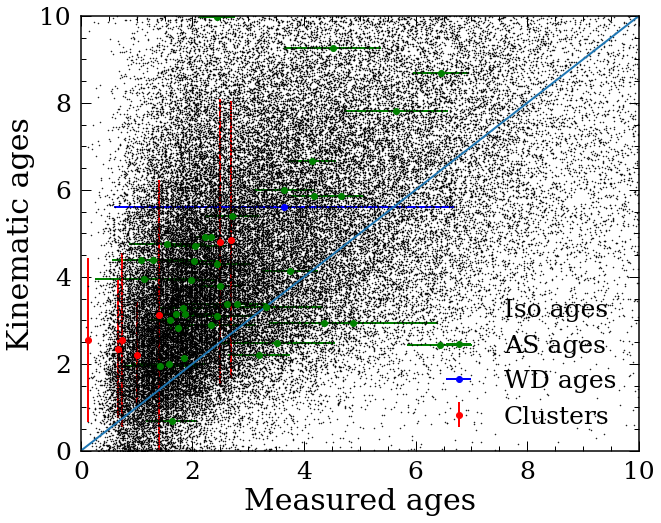

In [275]:
#df_ruth['kin_age']=df_ruth['age']
#df=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
#df.to_pickle('KinageAllKepler.pkl')
compstars(df,ave=False,err=False,IOfile=False)

In [232]:
df

,Prot,KID,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,...,bprp_dered,G_dered,teff_calc,abs_G,v_t,v_b,Prot_log,Ro,vel_dis,kin_age
0,1.569000,1026474,1.635721e+18,Gaia DR2 2050236143797351808,2.050236e+18,2.072963e+08,2015.5,291.149002,0.034903,36.723814,...,1.732713,15.406763,4026.558638,7.543278,17.702679,15.602643,0.195623,0.064496,0.245607,0.006665
1,15.678000,1162635,1.635721e+18,Gaia DR2 2050240885441462400,2.050241e+18,1.255228e+09,2015.5,291.334907,0.075467,36.806430,...,1.883901,15.669201,3892.908102,7.386176,20.490185,-11.929150,1.195291,0.438268,9.791014,2.212731
2,31.496000,1164102,1.635721e+18,Gaia DR2 2051695470602017280,2.051695e+18,1.503927e+09,2015.5,291.650936,0.021023,36.836871,...,1.710365,15.212092,4048.484918,7.526546,17.989548,13.596025,1.498255,1.153169,22.705863,8.324044
3,42.659000,1292688,1.635721e+18,Gaia DR2 2050254491897606784,2.050254e+18,1.351897e+09,2015.5,290.920348,0.032022,36.917263,...,2.023896,15.825297,3785.473785,8.599282,43.054099,-14.155903,1.630011,1.248297,26.832926,10.828729
4,27.333000,1297303,1.635721e+18,Gaia DR2 2051723954825689856,2.051724e+18,1.703474e+08,2015.5,291.958453,0.024110,36.999624,...,1.482390,15.398706,4316.554097,6.985246,22.581097,16.651520,1.436687,1.035395,12.713077,3.338742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35707,1.874974,12835232,1.635721e+18,Gaia DR2 2139271056353986560,2.139271e+18,7.372908e+08,2015.5,290.435721,0.022674,52.178068,...,1.920563,15.142816,3863.597356,7.415637,9.081078,-3.861716,0.272995,0.051568,7.573892,1.476692
35708,10.534756,12884110,1.635721e+18,Gaia DR2 2139312253680416128,2.139312e+18,4.611624e+08,2015.5,289.597971,0.025786,52.229048,...,1.055942,15.317932,5122.906288,5.791401,3.229439,-1.212178,1.022624,0.426464,7.729835,1.524865
35709,41.267193,12884445,1.635721e+18,Gaia DR2 2139308714627072128,2.139309e+18,1.644906e+09,2015.5,289.728559,0.022535,52.207544,...,1.603105,15.285842,4163.624695,7.273013,68.123474,-35.372596,1.615605,1.578790,30.801917,13.456811
35710,38.246140,12885258,1.635721e+18,Gaia DR2 2139319159987658112,2.139319e+18,3.352709e+08,2015.5,290.199203,0.024984,52.249039,...,1.146215,15.580801,4913.201762,5.921486,8.393855,6.894063,1.582588,2.051784,13.727714,3.767984
